In [ ]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from typing import Literal
from collections import defaultdict

sns.set_context("notebook")
sns.set_palette("deep")
color_palette = sns.color_palette()
color_palette

In [ ]:
FDF_GRAIN_SIZE: Literal["url", "context", "program"] = "url"

In [ ]:
OUT_PATH = Path('output')
IN_PATH = Path('input')

In [ ]:
df_raw = pd.read_pickle('output/0417-raf_final.pkl.zstd', compression='zstd')

In [ ]:
idx = (((df_raw['when_webgl'].notna()) | (df_raw['trace_status'] == 'Ok')) & ~(df_raw['raf'] == True) & (df_raw['label_ERROR'].isnull()))
df_raw[idx]

In [ ]:
def expand_and_merge(df_raw, col_name, prefix='', explode=False):
    if explode:
        df_tmp = df_raw[col_name].dropna().explode().dropna()
    else:
        df_tmp = df_raw[col_name].dropna()

    df_expand = pd.DataFrame(df_tmp.to_list(), index=df_tmp.index)
    df_ret = df_raw.drop(columns=[col_name]).merge(df_expand.add_prefix(prefix), left_index=True, right_index=True)
    return df_ret

In [ ]:
# df_raw = pd.read_pickle(IN_PATH / 'df-all-merged-1.pkl.zstd', compression='zstd')
# df_huls = df_raw[df_raw.gl_info.apply(lambda x: x['whenUsedWebgl'] is not None if x is not None else False)].copy()
df_gl_info = expand_and_merge(df_raw[['url', 'category', 'duration', 'gl_info_raf']], 'gl_info_raf', 'raf-', explode=False)
df_gl_info

In [ ]:
df_context = expand_and_merge(df_gl_info, 'raf-contextInfo', 'context-', explode=True)
df_context.index.name = 'index-url'
df_context.reset_index(inplace=True)
df_context.index.name = 'index-context'
df_context

In [ ]:
df_context = expand_and_merge(df_context, 'context-contextAttributes', 'context-contextAttributes-')
df_context = expand_and_merge(df_context, 'context-maghsk', 'context-maghsk-')
df_context = expand_and_merge(df_context, 'context-memoryInfo', 'context-memoryInfo-')

df_context = expand_and_merge(df_context, 'context-maghsk-counter', 'context-maghsk-counter-')
df_context = expand_and_merge(df_context, 'context-memoryInfo-memory', 'context-memoryInfo-memory-')
df_context = expand_and_merge(df_context, 'context-memoryInfo-resources', 'context-memoryInfo-resources-')

df_context['context-type'] = df_context['context-maghsk-createArguments'].str[0]

In [ ]:
df_context.loc[0].apply(lambda x: type(x)).to_dict()

In [ ]:
canvas_length = df_context.groupby('index-url')['url'].count()
canvas_length

Figure out why a webpage contains more than one canvas. List some urls and their canvas counts.

In [ ]:
# context length > 1
df_gl_info.loc[canvas_length[canvas_length > 1].index]

# In other words, could we detect the pattern of an empty canvas?

In [ ]:
# tmp = df_raw[df_raw['url'] == 'http://sonorannews.com'].gl_info.iloc[0]
# open(OUT_PATH / 'example' / 'tmp.json', 'w').write(json.dumps(tmp, indent=2))

# canvas sizes

In [ ]:
df_context.dtypes.to_dict()

In [ ]:
canvas_sizes = df_context['context-canvasSize'].dropna().to_list()
# plot the distribution of canvas size( as scatter plot)
plt.scatter([x[0] for x in canvas_sizes], [x[1] for x in canvas_sizes], s=1)
plt.xlim(0, 3200)
plt.ylim(0, 1800)
plt.show()
# count the canvas which size is larger than 3200x1800
len([x for x in canvas_sizes if x[0] > 3200 or x[1] > 1800])

In [ ]:
import re
def remove_whitespaces(s: str):
    return re.sub(r'\s+', '', s)

In [ ]:
remove_whitespaces("t est\nHelloworl d")

In [ ]:
df_program = expand_and_merge(df_context, 'context-programInfo', 'program-', explode=True)
df_program.reset_index(inplace=True)
df_program.index.name = 'index-program'
df_program

In [ ]:
df_vert_shaders = pd.DataFrame({'shader_source': df_program['program-vertexShaders'].explode().explode(), 'shader_type': 'vertex'})
df_frag_shaders = pd.DataFrame({'shader_source': df_program['program-fragmentShaders'].explode().explode(), 'shader_type': 'fragment'})
df_shaders = df_program.drop(columns=['program-vertexShaders', 'program-fragmentShaders']).merge(pd.concat([df_vert_shaders, df_frag_shaders], ignore_index=False), left_index=True, right_index=True)
df_shaders.dropna(subset=['shader_source'], inplace=True)
df_shaders.reset_index(inplace=True)
df_shaders.index.name = 'index-shader'
df_shaders['shader_length'] = df_shaders['shader_source'].str.len()

assert (df_shaders['shader_source'].apply(lambda x: type(x)) == str).all()
# df_shaders[df_shaders['shader_source'].apply(lambda x: type(x)) != str]

# Flatten ContextInfos

In [ ]:
# # fcontext_infos = [flatten_ctx_info(x) for x in context_infos]
# fcontext_infos = []
# fdf_columns = set()
# for x in context_infos:
#     fcontext_infos.append(flatten_ctx_info(x))
#     fdf_columns.update(flatten_ctx_info(x).keys())

# fdf = pd.DataFrame(fcontext_infos)
# # zip column name with dtype
# for x in fdf.columns.tolist():
#     print(x, fdf[x].dtype)

In [ ]:
# fdf.fillna(0, inplace=True)
# print((len(fdf[fdf['total_func_call'] == 0])))
# fdf_url = fdf.groupby('url').aggregate(np.sum)
# fdf = fdf[fdf['total_func_call'] > 0]
# fdf_url[fdf_url['total_func_call'] == 0].to_csv(OUT_PATH / 'total_func_call_0.csv')
# fdf_url[fdf_url['shader_count'] == 0].to_csv(OUT_PATH / 'shader_count_0.csv')
# fdf_url[fdf_url['program_count'] == 1].to_csv(OUT_PATH / 'program_count_1.csv')
# fdf_url[fdf_url['_memory_total'] == 0].to_csv(OUT_PATH / '_memory_total_0.csv')
# fdf_url = fdf_url[fdf_url['total_func_call'] > 0]
# fdf

In [ ]:
# len(fdf.url.unique())

# Context Type

In [ ]:
df_shaders.dtypes.to_dict()

In [ ]:
fig, axes = plt.subplots(figsize=(14, 5))

sns.countplot(y='context-type', data=df_shaders, ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('contextType')

for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(df_shaders)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')

plt.tight_layout()
plt.show()

# Power Preference

In [ ]:
fig, axes = plt.subplots(figsize=(14, 5))

sns.countplot(y='context-contextAttributes-powerPreference', data=df_context, ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('context-contextAttributes-powerPreference')

for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(df_context)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')

plt.tight_layout()
plt.show()

# Context Attrib

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))

sns.countplot(y='context-contextAttributes-depth', data=df_context, ax=axes[0,0])
axes[0,0].set_xlabel('Count')
axes[0,0].set_ylabel('context-contextAttributes-depth')

sns.countplot(y='context-contextAttributes-antialias', data=df_context, ax=axes[0,1])
axes[0,1].set_xlabel('Count')
axes[0,1].set_ylabel('context-contextAttributes-antialias')

sns.countplot(y='context-contextAttributes-stencil', data=df_context, ax=axes[1,0])
axes[1,0].set_xlabel('Count')
axes[1,0].set_ylabel('context-contextAttributes-stencil')

sns.countplot(y='context-contextAttributes-alpha', data=df_context, ax=axes[1,1])
axes[1,1].set_xlabel('Count')
axes[1,1].set_ylabel('context-contextAttributes-alpha')

for x in range(2):
    for y in range(2):
        for rect in axes[x,y].patches:
            axes[x,y].annotate(f'{rect.get_width()/len(df_context)*100:.1f}%', 
                                (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                                ha='left', va='center')

plt.tight_layout()
plt.show()

In [ ]:
# (fdf.when - fdf.whenUsedWebgl).describe()

# Extensions

In [ ]:
tmp = df_context['context-extensions'].apply(len)
print("percentage of context which has no extension: {:.2f}%".format((tmp == 0).sum() / len(tmp) * 100))

In [ ]:
with open('input/webgl-extension-categories.json', 'r') as fp:
    category_to_extension = json.load(fp)

extension_to_category = defaultdict(lambda: 'unknown')
for category, extensions in category_to_extension.items():
    for extension in extensions:
        extension_to_category[extension] = category

In [ ]:
extension_to_category['42']

In [ ]:
extension = df_context[df_context['context-extensions'].apply(len) > 0]['context-extensions']
tmp = extension.apply(lambda x: ';'.join(x)).value_counts().to_dict()
json.dump(tmp, open(OUT_PATH / 'example' / 'extension-count.json', 'w'), indent=2)
tmp2 = extension.apply(lambda x: ';'.join(x)).describe()
print(tmp2)
words_list = tmp2['top'].split(';')
tmp2 = []
for lst in extension:
    tmp2.extend(lst)

extension_df = pd.DataFrame({
    'name': pd.Series(tmp2),
    'category': pd.Series([extension_to_category[x] for x in tmp2]),
    'prefix': pd.Series([x.split('_')[0] for x in tmp2])
})
extension_df = extension_df[(extension_df['prefix'].str.len() > 2) & (extension_df['prefix'].str.upper() == extension_df['prefix'])]

tmp = extension_df['name'].value_counts(ascending=True)
# print(tmp.to_dict())
to_plot = tmp.iloc[len(tmp)-20:]
bar = to_plot.plot.barh(figsize=(20, 10))
for i, v in enumerate(to_plot.index):
    if v in words_list:
        bar.get_children()[i].set_color(sns.color_palette()[3])
    else:
        bar.get_children()[i].set_color(sns.color_palette()[0])
plt.title('Top 20 extensions')
plt.show()

In [ ]:
sorted(set(extension_df[extension_df['category'] == 'unknown'].name))

In [ ]:
extension_df['category'].value_counts()

## Extension 开发过程

Extension 在其发展过程中经历了四个阶段：建议、草案、社区批准和Khronos批准。每个 extension 都应该推进到Khronos的批准。如果一个 extension 不能通过 extension 过程来推进，它可以被拒绝。

- Proposed extensions 是为了在公共WebGL邮件列表中进行讨论，以便进入草案状态；它们不应该被实现，即使是在供应商的前缀下。如果在社区中达成了共识，该 extension 就可以转为草案状态。
- Draft extensions 可以在供应商的前缀下实现，或者在运行时选项后面实现，以达到实验的目的，以便在最终确定 extension 之前获得经验。草案 extension 不应默认由WebGL实现来公开。一旦在社区中达成共识，该 extension 就可以转为Community approved 状态。
- Community approved extensions 应该在没有供应商前缀的情况下实现。当一个 extension 草案转为社区认可状态时，任何现有的实现都应该立即取消对任何厂商前缀的 extension 名称的支持。一旦被厂商实现，除非该 extension 存在严重问题，如安全漏洞，否则不应取消支持。
- Khronos ratified extensions 是那些经过Khronos委员会投票通过的Community approved extension 。
- Rejected extensions（不应被实现）。扩展进入被拒绝状态是因为在提议阶段没有达成共识或在草案阶段实施过程中出现技术困难。只有在特殊情况下，社区批准的扩展才能被拒绝。Khronos认可的扩展不能被拒绝。

In [ ]:
# extension_category.value_counts().plot.barh(figsize=(20, 10))
# with percentage
fig, axes = plt.subplots(figsize=(20, 10))
sns.countplot(y=extension_df['category'], ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('Extension Category')
for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(extension_df)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')
plt.show()


## 命名约定

WebGL 扩展以“ANGLE”、“OES”、“EXT”、“WEBGL”等为前缀。这些前缀反映了来源和意图：

- `ANGLE_`: 由 ANGLE library 的作者编写的扩展。
- `OES_` 和 `KHR_`: 由各自的架构审查委员会（Khronos）批准的对 OpenGL ES（OES）或 OpenGL API 扩展的功能的镜像。
- `OVR_`: 针对虚拟现实进行优化的扩展。
- `EXT_`: 从其他 OpenGL ES 或 OpenGL API 扩展镜像的扩展。
- `WEBGL_`: 特定于 WebGL 的扩展，旨在与多种 Web 浏览器兼容。它也应该用于源自 OpenGL ES 或 OpenGL API 的扩展，但其行为已被显著改变。

In [ ]:
# extension_category.value_counts().plot.barh(figsize=(20, 10))
# with percentage
fig, axes = plt.subplots(figsize=(20, 10))
sns.countplot(y=extension_df['prefix'], ax=axes, order=extension_df['prefix'].value_counts().index)
axes.set_xlabel('Count')
axes.set_ylabel('Extension Prefix')
for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(extension_df)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')
# hatch='///' on MOZ WEBKIT OCULUS
for i in [4,5,8]:
    axes.patches[i].set_hatch('///')
    axes.patches[i].set_facecolor('white')
    axes.patches[i].set_edgecolor(color_palette[i])
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(26, 16))
tmp = extension_df.value_counts(subset=['prefix', 'category'])
tmp = tmp.reset_index()
tmp.columns = ['prefix', 'category', 'count']
tmp
sns.barplot(x='count', y='category', hue='prefix', data=tmp, ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('Extension Prefix')
for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(extension_df)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
# tmp = extension.apply(lambda x: ';'.join(x))
# df_context[df_context.extensions.apply(len) > 0][tmp.str.contains('BdwhLT1F')]

In [ ]:
# extension.describe()

# WebGL calls

In [ ]:
total_func_call = pd.DataFrame(df_context['context-maghsk-counter-funcCount'].to_list(), index=df_context.index).sum(axis=1)

In [ ]:
print(total_func_call.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
# df_context[total_func_call < 100].total_func_call.value_counts().sort_index().plot(kind='bar', figsize=(20, 10))
total_func_call[total_func_call < total_func_call.quantile(0.99)].plot(kind='hist', bins=100, figsize=(20, 10))
plt.show()

# shader!

In [ ]:
df_shaders

In [ ]:
tmp = OUT_PATH / 'example' / 'sampled_shaders'
for index_shader, row in df_shaders.sample(10).iterrows():
    shader = row.shader_source
    typ = row.shader_type
    index_url = row['index-url']
    index_context = row['index-context']
    index_program = row['index-program']
    with open(tmp / f'{index_url}-{index_context}-{index_program}-{index_shader}.{typ}', 'w') as f:
        f.write(shader)

## Diversity of shaders

In [ ]:
import hashlib

In [ ]:
df_shaders_trim = df_shaders
# df_shaders_trim['shader_source_trimmed_hashed'] = df_shaders_trim['shader_source'].apply(remove_whitespaces).apply(hashlib.sha256).apply(lambda x: x.hexdigest())
df_shaders_trim['shader_source_trimmed_hashed'] = df_shaders_trim['shader_source'].apply(lambda x: hashlib.sha256(remove_whitespaces(x).encode('utf-8')).hexdigest())
df_shaders_trim

### Context Level

In [ ]:
# group by source and count the different urls
df_source_count = df_shaders_trim.groupby('shader_source_trimmed_hashed')[['index-program','index-context','index-url']].nunique()
tmp = df_shaders_trim.set_index('shader_source_trimmed_hashed')[['shader_type','shader_source','shader_length']]
tmp = tmp[~tmp.index.duplicated(keep='first')]
df_source_count = df_source_count.join(tmp, how='inner')
df_source_count.reset_index(inplace=True)
df_source_count.index.name = 'index-source'
df_source_count

In [ ]:
df_source_count[['index-program','index-context','index-url']].sum(axis=0)

In [ ]:
plt.title("By context")
plt.xlabel('Shader ID')
plt.ylabel('Number of Contexts')
df_source_count.sort_values('index-context', ascending=False).head(50)['index-context'].plot(kind='bar', figsize=(20, 10))


In [ ]:
# plt.figure(figsize=(30, 50))
plt.title("By URL (length/count)")
plt.xlabel('Number of URLs')
plt.ylabel('Shader ID')

tmp = df_source_count.sort_values('index-url', ascending=False).head(50)
bar = tmp['index-url'].plot(kind='barh', figsize=(30, 50))
# bar = sns.barplot(x='url_count', y='index', hue='type', data=tmp, orient='h')
# label length on top of bar
for rect, url_count, length in zip(bar.patches,tmp['index-url'],tmp['shader_length']):
    bar.annotate(f'{url_count}',
                    (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                    ha='left', va='center')
    bar.annotate(f'{length}',
                    (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                    ha='right', va='center', color='white')
    
plt.show()

In [ ]:
df_shaders_trim.head(2)

In [ ]:
subset = ['shader_source_trimmed_hashed']
df_shaders_trim_dedup = df_shaders_trim.drop_duplicates(subset=subset, keep='first')
tmp = len(df_shaders_trim_dedup) / len(df_shaders_trim) * 100
print("Percentage of all unique shaders: {:.2f}%".format(tmp * 100))
plt.figure(figsize=(8, 8))
plt.rcParams.update()
plt.pie([tmp, 100-tmp], labels=['Unique', 'Duplicated'], autopct='%.2f%%')
plt.title('By {}'.format(subset))
plt.show()

In [ ]:
subset = ['shader_source_trimmed_hashed', 'index-url']
df_shaders_trim_dedup = df_shaders_trim.drop_duplicates(subset=subset, keep='first')
tmp = len(df_shaders_trim_dedup) / len(df_shaders_trim) * 100
print("Percentage of all unique shaders: {:.2f}%".format(tmp * 100))
plt.figure(figsize=(8, 8))
plt.rcParams.update()
plt.pie([tmp, 100-tmp], labels=['Unique', 'Duplicated'], autopct='%.2f%%')
plt.title('By {}'.format(subset))
plt.show()

In [ ]:
subset = ['shader_source_trimmed_hashed', 'index-context']
df_shaders_trim_dedup = df_shaders_trim.drop_duplicates(subset=subset, keep='first')
tmp = len(df_shaders_trim_dedup) / len(df_shaders_trim) * 100
print("Percentage of all unique shaders: {:.2f}%".format(tmp * 100))
plt.figure(figsize=(8, 8))
plt.rcParams.update()
plt.pie([tmp, 100-tmp], labels=['Unique', 'Duplicated'], autopct='%.2f%%')
plt.title('By {}'.format(subset))
plt.show()

In [ ]:
subset = ['shader_source_trimmed_hashed', 'index-program']
df_shaders_trim_dedup = df_shaders_trim.drop_duplicates(subset=subset, keep='first')
tmp = len(df_shaders_trim_dedup) / len(df_shaders_trim) * 100
print("Percentage of all unique shaders: {:.2f}%".format(tmp * 100))
plt.figure(figsize=(8, 8))
plt.rcParams.update()
plt.pie([tmp, 100-tmp], labels=['Unique', 'Duplicated'], autopct='%.2f%%')
plt.title('By {}'.format(subset))
plt.show()

Percentage of all unique shaders by ['shader_source_trimmed_hashed']: 5165.32%
Percentage of all unique shaders by ['shader_source_trimmed_hashed', 'index-url']: 6734.77%
Percentage of all unique shaders by ['shader_source_trimmed_hashed', 'index-context']: 7206.54%
Percentage of all unique shaders by ['shader_source_trimmed_hashed', 'index-program']: 9892.47%


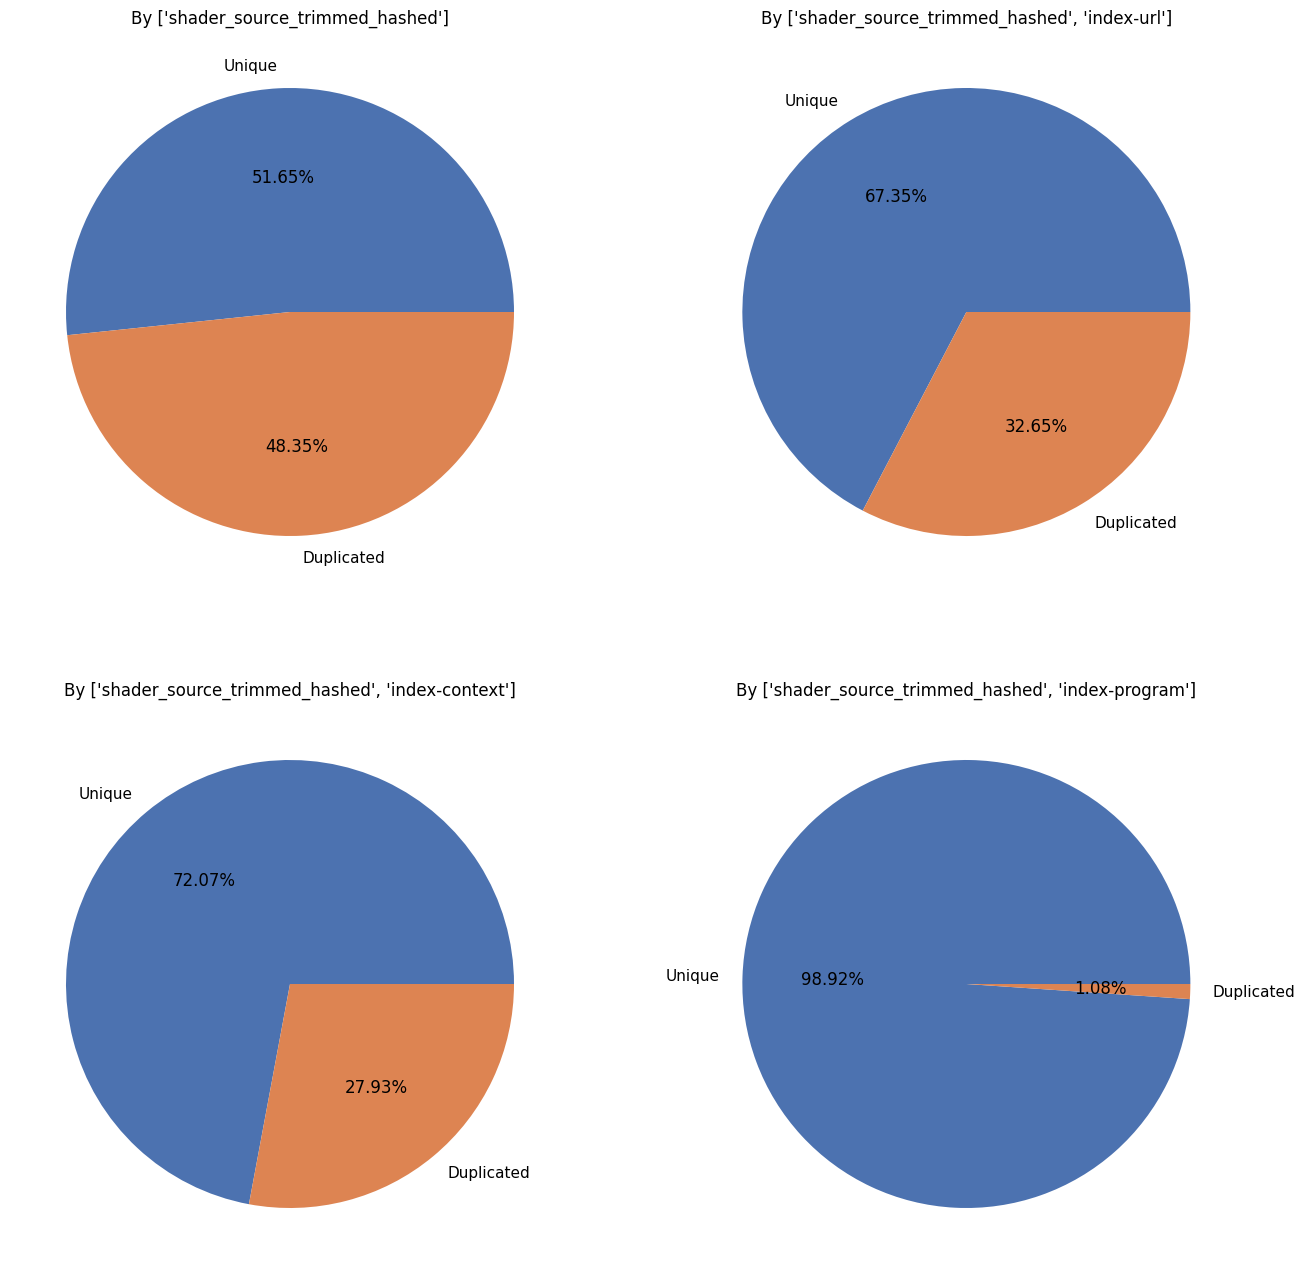

In [69]:
# create figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# add four figures above to the figure
subset = [['shader_source_trimmed_hashed'], ['shader_source_trimmed_hashed', 'index-url'], ['shader_source_trimmed_hashed', 'index-context'], ['shader_source_trimmed_hashed', 'index-program']]
for i in range(4):
    df_shaders_trim_dedup = df_shaders_trim.drop_duplicates(subset=subset[i], keep='first')
    tmp = len(df_shaders_trim_dedup) / len(df_shaders_trim) * 100
    print("Percentage of all unique shaders by {}: {:.2f}%".format(subset[i], tmp * 100))
    axes[i//2][i%2].pie([tmp, 100-tmp], labels=['Unique', 'Duplicated'], autopct='%.2f%%')
    axes[i//2][i%2].set_title('By {}'.format(subset[i]))
plt.show()

In [ ]:
# TODO

## Shader Count

In [ ]:
print('==0', fdf[fdf['shader_count'] == 0].total_func_call.describe())
# plot shader_count
tmp = fdf['shader_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
sns.histplot(data=fdf[fdf['shader_count'] < tmp['99%']], x="shader_count", multiple="stack")
plt.plot()
fdf[fdf['shader_count'] > 4000][['url', 'shader_count', 'program_count', '_resources_shader', '_resources_program']]


In [ ]:
tmp = fdf_url.loc[fdf_url['shader_count']==0].copy()

In [ ]:
# remove columns that sum=0
for x in tmp.columns:
    if tmp[x].sum() == 0:
        tmp.drop(x, axis=1, inplace=True)

In [ ]:
tmp.to_excel(OUT_PATH / 'example' / 'shader_count_is_0.xlsx')

In [ ]:
print('==0', fdf_url[fdf_url['shader_count'] == 0].total_func_call.describe())
# plot shader_count
tmp = fdf_url['shader_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
sns.histplot(data=fdf_url[fdf_url['shader_count'] < tmp['99%']], x="shader_count", element='step')
plt.plot()
fdf_url[fdf_url['shader_count'] > 4000][['shader_count', 'program_count', '_resources_shader', '_resources_program']]

## shader length

In [ ]:
print(shader_df.source_length.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

In [ ]:
tmp = shader_df.source_length.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
plt.figure(figsize=(10, 5))
plt.xlim(0, tmp['99%'])
sns.histplot(data=shader_df, x="source_length", hue="type", multiple="layer", element="step")
plt.plot()

In [ ]:
# vert, frag shaderlength median/ mean
shader_df_vert = shader_df[shader_df.type == 'vert']
shader_df_frag = shader_df[shader_df.type == 'frag']

print('vert', shader_df_vert.describe())
print('frag', shader_df_frag.describe())

# Programs

In [ ]:
tmp = fdf['program_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
sns.histplot(data=fdf[fdf['program_count'] < tmp['99%']], x="program_count", multiple="stack", color=sns.color_palette()[2])
plt.plot()

# Textures

In [ ]:
# plot shader_count
tmp = fdf['_resources_texture'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
plt.title('Texture count (99%)')
sns.histplot(data=fdf[fdf['_resources_texture'] < tmp['99%']], x="_resources_texture", multiple="stack")
plt.plot()
fdf[fdf['_resources_texture'] > 2000]

In [ ]:
# plot shader_count
tmp = fdf['_func_call_createTexture'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
plt.xlim(0, tmp['99%'])
plt.title('Texture count (99%)')
sns.histplot(data=fdf, x="_func_call_createTexture", multiple="stack")
# sns.histplot(data=fdf_after, x="_resources_shader", multiple="stack")
plt.plot()
fdf[fdf['_func_call_createTexture'] > 2000]

# VAO

In [ ]:
# plot shader_count
tmp = fdf['_func_call_createVertexArray'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
plt.title('_func_call_createVertexArray count (99%)')
sns.histplot(data=fdf[fdf['_func_call_createVertexArray'] < tmp['99%']], x="_func_call_createVertexArray", multiple="stack", bins=50)
# sns.histplot(data=fdf_after, x="_resources_shader", multiple="stack")
plt.plot()
fdf[fdf['_func_call_createVertexArray'] > 2000]

# Memory Total (roughly)

In [ ]:
tmp = fdf['_memory_total'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
sns.histplot(data=fdf[fdf['_memory_total'] < tmp['99%']], x="_memory_total", multiple="stack")
plt.plot()

# Vertex & Triangle

In [ ]:
fdf['vertexCount'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

In [ ]:
fdf[fdf['vertexCount'] == 0][['url', '_func_call_drawElements', '_func_call_drawArrays', '_func_call_drawBuffers', '_func_call_drawElementsInstanced', '_func_call_drawArraysInstanced']]

In [ ]:
fdf['triangleCount'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

# RequestAnimationFrame(RAF)

In [ ]:
print(fdf.rafCalled_total.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
sns.histplot(data=fdf, x="rafCalled_total", multiple="stack")
plt.title('Total RAF called')
plt.plot()

In [ ]:
print(fdf.rafCalled_max.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
sns.histplot(data=fdf, x="rafCalled_max", multiple="stack")
plt.title('Max RAF called')
plt.plot()